#  News Topic Classifier

End-to-end ML/NLP project you can run locally.

**Highlights**
- Dataset: scikit-learn **20 Newsgroups** (text classification)
- Pipeline: **TF‑IDF** → **LinearSVC**
- EDA, metrics, confusion matrix, **top features per class**
- **GridSearchCV** for hyperparameter tuning
- Save & load model with **joblib**

In [7]:
import sys, os, numpy as np, pandas as pd, matplotlib
import sklearn
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

Python: 3.11.13
pandas: 2.3.3
numpy: 2.3.3
scikit-learn: 1.7.2
matplotlib: 3.10.6


## 1) Load Dataset

In [8]:
from sklearn.datasets import fetch_20newsgroups

# Choosing a subset of categories to keep training fast & balanced
categories = [
    "comp.graphics",
    "rec.autos",
    "sci.space",
    "sci.med",
    "rec.sport.baseball",
    "talk.politics.mideast",
    "talk.religion.misc",
    "comp.sys.ibm.pc.hardware",
]

remove = ("headers", "footers", "quotes")

train_data = fetch_20newsgroups(subset="train", categories=categories, remove=remove)
test_data  = fetch_20newsgroups(subset="test",  categories=categories, remove=remove)

X_train, y_train = train_data.data, train_data.target
X_test,  y_test  = test_data.data,  test_data.target
target_names = train_data.target_names

len(X_train), len(X_test), target_names[:5]

(4493,
 2991,
 ['comp.graphics',
  'comp.sys.ibm.pc.hardware',
  'rec.autos',
  'rec.sport.baseball',
  'sci.med'])

## 2) EDA

In [9]:
import pandas as pd, numpy as np
train_df = pd.DataFrame({"text": X_train, "y": y_train})
train_df["label"] = train_df["y"].apply(lambda i: target_names[i])
print(train_df["label"].value_counts())
train_df.sample(3)[["label", "text"]]

label
rec.sport.baseball          597
sci.med                     594
rec.autos                   594
sci.space                   593
comp.sys.ibm.pc.hardware    590
comp.graphics               584
talk.politics.mideast       564
talk.religion.misc          377
Name: count, dtype: int64


,label,text
1974,rec.autos,\n\n What I don't understand is why \n\n\n\nYe...
2835,sci.space,\nVoyager has the unusual luck to be on a st...
536,talk.politics.mideast,"\nOY] Henrik (?),\nOY] Your ignorance manifest..."


## 3) Build Pipeline & Train

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", LinearSVC(C=1.0))
])

pipe.fit(X_train, y_train)
"Model trained!" 

'Model trained!'

## 4) Evaluate

Accuracy: 0.8385
                          precision    recall  f1-score   support

           comp.graphics       0.82      0.83      0.82       389
comp.sys.ibm.pc.hardware       0.88      0.87      0.88       392
               rec.autos       0.72      0.89      0.80       396
      rec.sport.baseball       0.88      0.88      0.88       397
                 sci.med       0.85      0.83      0.84       396
               sci.space       0.87      0.79      0.83       394
   talk.politics.mideast       0.90      0.86      0.88       376
      talk.religion.misc       0.83      0.71      0.76       251

                accuracy                           0.84      2991
               macro avg       0.84      0.83      0.84      2991
            weighted avg       0.84      0.84      0.84      2991



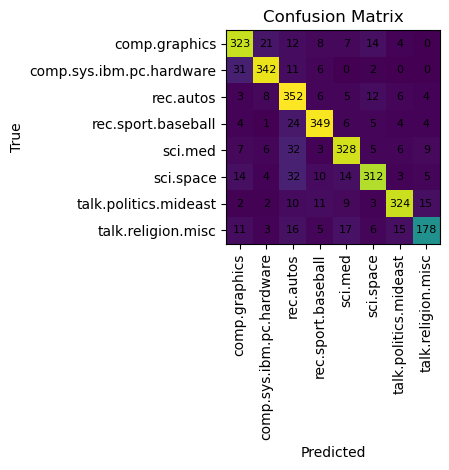

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

preds = pipe.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, preds), 4))
print(classification_report(y_test, preds, target_names=target_names))

cm = confusion_matrix(y_test, preds)
fig = plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xticks(range(len(target_names)), target_names, rotation=90)
plt.yticks(range(len(target_names)), target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

## 5) Top Features per Class

In [12]:
# Extract top features using LinearSVC coefficients
clf = pipe.named_steps["clf"]
tfidf = pipe.named_steps["tfidf"]
feature_names = np.array(tfidf.get_feature_names_out())

def top_terms_per_class(class_index, top_n=15):
    # For LinearSVC (one-vs-rest), coef_ shape = [n_classes, n_features]
    coefs = clf.coef_[class_index]
    top_ids = np.argsort(coefs)[-top_n:][::-1]
    return feature_names[top_ids]

for i, name in enumerate(target_names):
    print(f"\nTop terms for class: {name}")
    print(", ".join(top_terms_per_class(i)))


Top terms for class: comp.graphics
graphics, image, 3d, 68070, file, package, code, animation, files, 3do, algorithm, pov, images, tiff, polygon

Top terms for class: comp.sys.ibm.pc.hardware
monitor, drive, card, motherboard, scsi, disk, pc, bios, port, memory, bus, board, ide, gateway, cpu

Top terms for class: rec.autos
car, cars, ford, oil, engine, dealer, toyota, auto, honda, gt, vw, tires, bmw, ites, rear

Top terms for class: rec.sport.baseball
baseball, stadium, team, cubs, game, games, year, players, ball, phillies, season, alomar, league, braves, teams

Top terms for class: sci.med
doctor, medical, msg, disease, treatment, health, cancer, pain, effects, diet, needles, drugs, patients, skin, eye

Top terms for class: sci.space
space, orbit, spacecraft, nasa, launch, moon, shuttle, solar, flight, dc, earth, lunar, mars, mining, centaur

Top terms for class: talk.politics.mideast
israel, israeli, jews, turkish, loser, arab, armenians, retarded, turkey, arabs, armenian, peace, l

## 6) Hyperparameter Tuning (GridSearchCV)

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.5, 1.0, 2.0]
}
grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", round(grid.best_score_, 4))

best_model = grid.best_estimator_
print("Test accuracy (best model):", round(accuracy_score(y_test, best_model.predict(X_test)), 4))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__C': 0.5, 'tfidf__ngram_range': (1, 1)}
Best CV score: 0.848
Test accuracy (best model): 0.8392


## 7) Save Model & Try Predictions

In [14]:
import joblib, os

artifact = os.path.abspath("news_topic_svm.joblib")
joblib.dump(best_model, artifact)
print("Saved model to:", artifact)

# Attach target_names to the pipeline for the Streamlit app
setattr(best_model, "target_names_", target_names)

def predict(texts):
    pred_idx = best_model.predict(texts)
    return [target_names[i] for i in pred_idx]

samples = [
    "The Hubble telescope captured new images of a distant galaxy cluster.",
    "My new graphics card struggles with ray tracing in the latest game.",
    "The team traded two pitchers before the baseball season opener."
]
predict(samples)

Saved model to: /Users/bandaanusha/Documents/AI-Projects/news_topic_svm.joblib


['sci.space', 'comp.graphics', 'rec.sport.baseball']